In [2]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import nltk

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as mlpt
import yfinance as yf

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/moh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### ELON MUSK TWEETS

In [193]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("neelgajare/all-elon-musk-tweets-2022-updated")

print("Path to dataset files:", path)

elon_tweets_df = pd.read_csv("data/elonmusk.csv" ,index_col=0 , parse_dates=['Timestamp'])
elon_tweets_df['Timestamp'] = pd.to_datetime(elon_tweets_df['Timestamp'])
elon_tweets_df['Timestamp'] = elon_tweets_df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
elon_tweets_df = elon_tweets_df.loc[(elon_tweets_df['Timestamp'] > '2018-06-1') & (elon_tweets_df['Timestamp']  < '2020-06-02')]
elon_tweets_df = elon_tweets_df[['Timestamp', 'text']]

Path to dataset files: /home/moh/.cache/kagglehub/datasets/neelgajare/all-elon-musk-tweets-2022-updated/versions/2


####  #TESTLA TWEETS 2022-04-10 2022-11-12

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hindy51/tesla-tweets")

print("Path to dataset files:", path)
tesla_tweet_df = pd.read_csv("data/Hashtag Tesla Tweets.csv"  , parse_dates=['Date & Time'])
tesla_tweet_df = tesla_tweet_df[['Date & Time', 'Tweet Text']]
tesla_tweet_df['Date & Time'] = pd.to_datetime(tesla_tweet_df['Date & Time'])
tesla_tweet_df['Date & Time'] = tesla_tweet_df['Date & Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
tesla_tweet_df = tesla_tweet_df.rename(columns={'Date & Time': 'Timestamp', 'Tweet Text': 'text'})

Path to dataset files: /home/moh/.cache/kagglehub/datasets/hindy51/tesla-tweets/versions/1


/tmp/ipykernel_12147/437996522.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tesla_tweet_df = pd.read_csv("data/Hashtag Tesla Tweets.csv"  , parse_dates=['Date & Time'])


### TESLA STOCK MARKET

In [199]:
def fetch_tesla_stock_market_data(start_date , end_date):
    ticker_symbol = 'TSLA'
    tesla_data_market = yf.download(ticker_symbol, start=start_date, end=end_date)
    tesla_data_market['Ticker'] = ticker_symbol
    tesla_data_market['7_Day_MA'] = tesla_data_market['Close'].rolling(window=7).mean()
    tesla_data_market['20_Day_MA'] = tesla_data_market['Close'].rolling(window=20).mean()
    tesla_data_market.columns = tesla_data_market.columns.droplevel('Ticker')
    tesla_data_market.head()
    return tesla_data_market

### Pre processing TESLA tweets

In [6]:
import re

def prerprocessing_text(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', text)
    text = re.sub(r'{link}', '', text)
    text = re.sub(r"\[video\]", '', text)
    text = re.sub(r'&[a-z]+;', '', text)
    text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', text)
    text = re.sub(r'@mention', '', text)
    return text


In [7]:
analyzer=SentimentIntensityAnalyzer()
def sentiment_analysis(tweet):
    score = analyzer.polarity_scores(tweet)["compound"]
    return score

In [20]:
def create_clean_data_frame(data_frame):
    df_clean_tweets = pd.DataFrame()
    df_clean_tweets['date_time'] = data_frame['Timestamp']
    df_clean_tweets['tweet_text'] = data_frame['text'].apply(prerprocessing_text)
    df_clean_tweets['date_time'] = pd.to_datetime(df_clean_tweets["date_time"])
    df_clean_tweets['compound'] = df_clean_tweets['tweet_text'].apply(sentiment_analysis)
    df_clean_tweets['day'] = df_clean_tweets["date_time"].dt.to_period("D")
    df_clean_tweets = df_clean_tweets.groupby("day")["compound"].mean().reset_index()
    df_clean_tweets.index = df_clean_tweets["day"]
    df_clean_tweets = df_clean_tweets.drop(columns=["day"])
    return df_clean_tweets

In [173]:
def merge_data(data_maket, df_clean_tweets , columns_name):
    compound_list = []
    for i in range(data_maket.shape[0]):
        date = data_maket.index[i]    
        try:
            compound_list.append(df_clean_tweets.loc[date.strftime("%Y-%m-%d")]['compound'])
        except:
            compound_list.append(0)
    data_maket['compound'] = compound_list
    data_maket = data_maket[columns_name]

    return data_maket

### The stock prediction
###### Use six models for predications the stock market

In [239]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prerprocessing_df_market(data_frame ,columns_name):
    X = data_frame[20:][columns_name]
    y = data_frame[20:]['Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, y_train , X_test_scaled, y_test


Train on:
- Linear Regression (LR)
- Decision Trees (DT)
- Random Forest Regressor (RF)
- Support Vector Regressor (SVR)
- Extreme Gradient Boosting (XG Boost)
- Facebook Prophet (FBS)

In [240]:
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from prophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score

def train(X_train, y_train, X_test, y_test):
    def train_on_model(model, X_train, y_train, X_test , y_test):
        model[1].fit(X_train, y_train)
        predictions =  model[1].predict(X_test)
        print(f"{model[0]} Model:")
        print(f"        Mean Squared Error: {mean_squared_error(y_test, predictions)}")
        print(f"        R^2 Score: {r2_score(y_test, predictions)}")

        return predictions

    models = {
        "LR": LinearRegression(),
        "DT" : DecisionTreeRegressor(),
        "RF" : RandomForestRegressor(),
        "SVM" : SVR(),
        "XGB" : XGBRegressor(),
    }
    result = {}
    for model in models.items():
        result[model[0]] =  train_on_model(model, X_train, y_train, X_test, y_test)

    return pd.DataFrame(result)


def train_on_prophet_model(tesla_data_market ,columns_name):
    test_size = '.3'
    data_set_len = tesla_data_market.shape[0]-20
    prophet_df = tesla_data_market.copy()[20:]
    prophet_df['ds'] = tesla_data_market[20:].index.strftime('%Y-%m-%d').values
    prophet_df = prophet_df.rename(columns={'Close': 'y'})
    prophet_df = prophet_df.reset_index(drop=True)
    prophet_model = Prophet()
    for item in columns_name:
        prophet_model.add_regressor(item , standardize=False)
        prophet_model.add_regressor( item , standardize=False)
        prophet_model.add_regressor( item , standardize=False)
    
    df_propohet_train = prophet_df[:data_set_len - int(data_set_len * float(test_size))]
    df_propohet_test = prophet_df[data_set_len-int(data_set_len * float(test_size)):]

    scaler = StandardScaler()
    df_propohet_train_scaled = df_propohet_train.copy()
    df_propohet_train_scaled[['y'] + columns_name] = scaler.fit_transform(df_propohet_train.drop(['ds'] ,axis=1))

    df_propohet_test_scaled = df_propohet_test.copy()
    df_propohet_test_scaled[['y'] + columns_name] = scaler.transform(df_propohet_test.drop(['ds'] , axis=1))

    prophet_model.fit(df_propohet_train_scaled)
    forecast = prophet_model.predict(df_propohet_test_scaled.drop(['y'] ,axis=1))

    print("Prophet Model:")
    print(f"        Mean Squared Error: {mean_squared_error(df_propohet_test_scaled['y'], forecast['yhat'])}")
    print(f"        R^2 Score: {r2_score(df_propohet_test_scaled['y'], forecast['yhat'])}")

In [218]:
def draw_compound_chart(compound_list):
    positive = 0
    negetive = 0
    neutrual = len(compound_list) - positive - negetive
    for item in compound_list:
        if item > 0.05:
            positive +=1
        elif item < -0.05:
            negetive += 1
        else:
            neutrual += 1
    arr=np.asarray([
        positive,
        negetive,
        neutrual
    ], dtype=int)
    mlpt.bar(['positive','negative' , 'neutrual'] , arr)
    mlpt.plot()    

#### Result on #Tesla tweets

1- The outcomes of the #tesla tweets dataset with moving averages for 7, 20 days

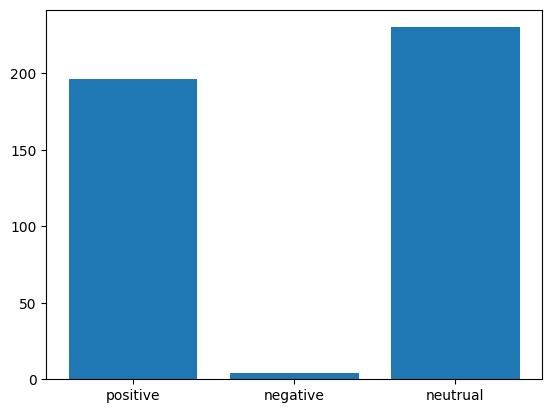

In [219]:
tesla_tweet_df_clean = create_clean_data_frame(tesla_tweet_df)
draw_compound_chart(tesla_tweet_df_clean['compound'])

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

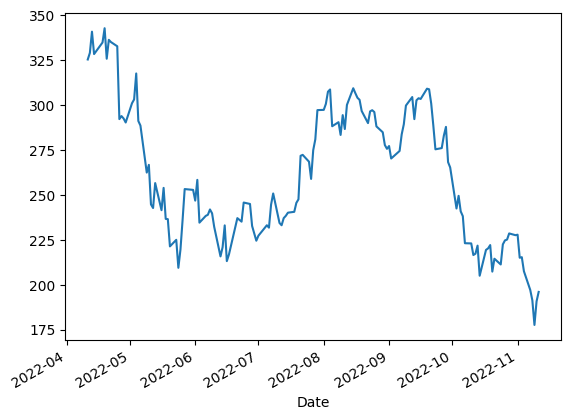

In [223]:
tesla_data_market = fetch_tesla_stock_market_data(start_date = '2022-04-10' , end_date = '2022-11-12')
tesla_data_market['Close'].plot()

LR Model:
        Mean Squared Error: 133.76180170078408
        R^2 Score: 0.8720574902587148
DT Model:
        Mean Squared Error: 246.8218029230021
        R^2 Score: 0.7639161515222573
RF Model:
        Mean Squared Error: 153.82601721080627
        R^2 Score: 0.8528661661609382
SVM Model:
        Mean Squared Error: 484.94156042305605
        R^2 Score: 0.5361557669717214
XGB Model:
        Mean Squared Error: 154.38646170565
        R^2 Score: 0.8523301037400584


23:28:04 - cmdstanpy - INFO - Chain [1] start processing
23:28:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model:
        Mean Squared Error: 1.203342926969628
        R^2 Score: -0.03186269446975931


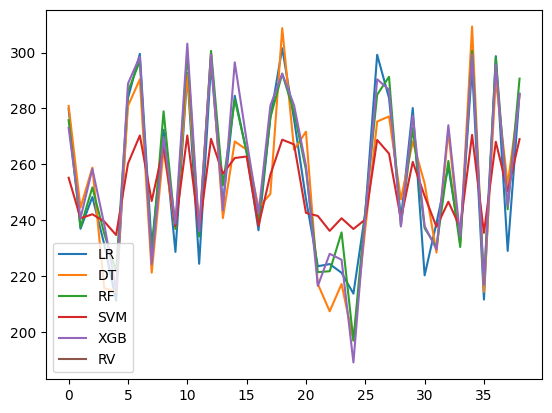

In [ ]:
columns_name = ['compound' , '7_Day_MA' , '20_Day_MA']
merged_df = merge_data(tesla_data_market, tesla_tweet_df_clean , ['Close'] + columns_name)
X_train, y_train, X_test, y_test = prerprocessing_df_market(merged_df , columns_name)
result = train(X_train, y_train, X_test, y_test)
result['RV'] = y_test
result.plot()
train_on_prophet_model(merged_df , columns_name)

2- The outcomes of #tesla tweets dataset without moving averages days

LR Model:
        Mean Squared Error: 1021.3819138200525
        R^2 Score: 0.02305319009673157
DT Model:
        Mean Squared Error: 2327.6056190646455
        R^2 Score: -1.2263434015131316
RF Model:
        Mean Squared Error: 1791.657618253008
        R^2 Score: -0.7137117574803094
SVM Model:
        Mean Squared Error: 1151.9738616810905
        R^2 Score: -0.10185736993534311
XGB Model:
        Mean Squared Error: 1876.3910252206172
        R^2 Score: -0.7947588472213416


23:29:04 - cmdstanpy - INFO - Chain [1] start processing
23:29:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model:
        Mean Squared Error: 10.370767027753457
        R^2 Score: -7.892899413074719


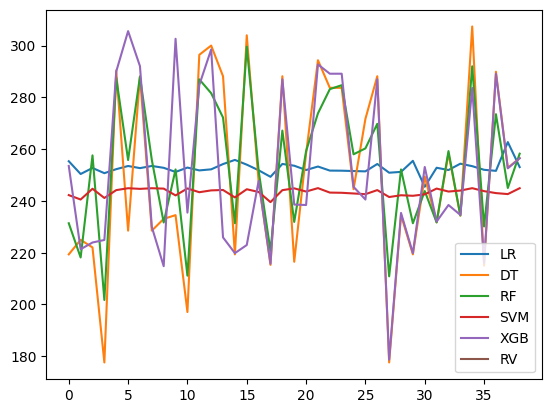

In [242]:
columns_name = ['compound']
tesla_tweet_df_clean = create_clean_data_frame(tesla_tweet_df)
merged_df = merge_data(tesla_data_market, tesla_tweet_df_clean , ['Close'] + columns_name)
X_train, y_train, X_test, y_test = prerprocessing_df_market(merged_df , columns_name)
result = train(X_train, y_train, X_test, y_test)
result['RV'] = y_test
result.plot()
train_on_prophet_model(merged_df , columns_name)

3- The outcomes of the tesla market without compound between  '2022-04-10' - '2022-11-12'

LR Model:
        Mean Squared Error: 133.56938382968627
        R^2 Score: 0.8722415370122296
DT Model:
        Mean Squared Error: 245.83672878828546
        R^2 Score: 0.7648583701188549
RF Model:
        Mean Squared Error: 151.3865826144714
        R^2 Score: 0.8551994734327928
SVM Model:
        Mean Squared Error: 424.11533308686836
        R^2 Score: 0.5943357562103098
XGB Model:
        Mean Squared Error: 222.65298403124922
        R^2 Score: 0.7870335086987892


23:29:26 - cmdstanpy - INFO - Chain [1] start processing
23:29:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model:
        Mean Squared Error: 1.188784016248393
        R^2 Score: -0.019378475292778585


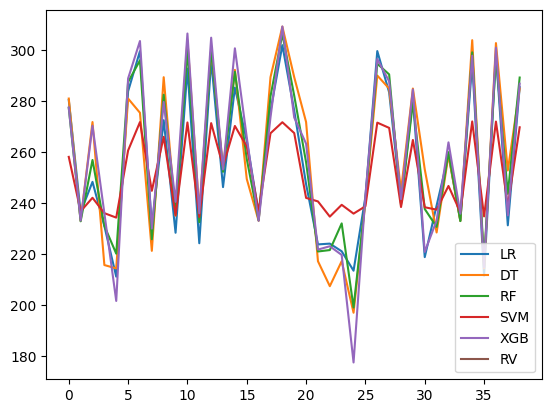

In [243]:
columns_name = ['7_Day_MA' , '20_Day_MA']
merged_df = tesla_data_market[['Close'] + columns_name]
X_train, y_train, X_test, y_test = prerprocessing_df_market(merged_df , columns_name)
result = train(X_train, y_train, X_test, y_test)
result['RV'] = y_test
result.plot()
train_on_prophet_model(merged_df , columns_name)

#### Result on Elon Musk's tweets

4- The outcomes of Elon Musk’s tweets dataset without moving averages for 7, 20 days


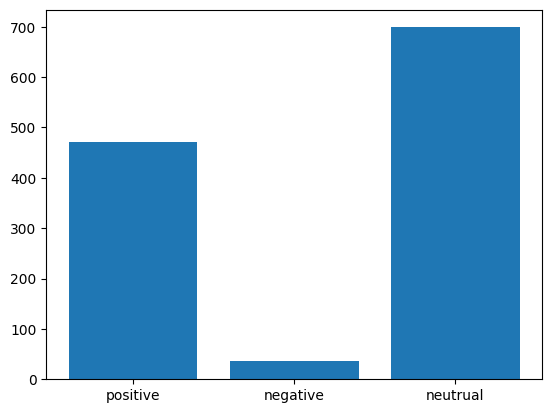

In [244]:
elon_tweet_df_clean = create_clean_data_frame(elon_tweets_df)
draw_compound_chart(elon_tweet_df_clean['compound'])

[*********************100%***********************]  1 of 1 completed


LR Model:
        Mean Squared Error: 92.67777777578637
        R^2 Score: 0.9934771956806705
DT Model:
        Mean Squared Error: 129.9461973700272
        R^2 Score: 0.9908541870788456
RF Model:
        Mean Squared Error: 95.0566668018888
        R^2 Score: 0.9933097658179023
SVM Model:
        Mean Squared Error: 1669.6233739494835
        R^2 Score: 0.8824893430051954


23:30:35 - cmdstanpy - INFO - Chain [1] start processing
23:30:35 - cmdstanpy - INFO - Chain [1] done processing


XGB Model:
        Mean Squared Error: 100.26013047336876
        R^2 Score: 0.9929435380540697
Prophet Model:
        Mean Squared Error: 0.04206169908880255
        R^2 Score: 0.9246926167885734


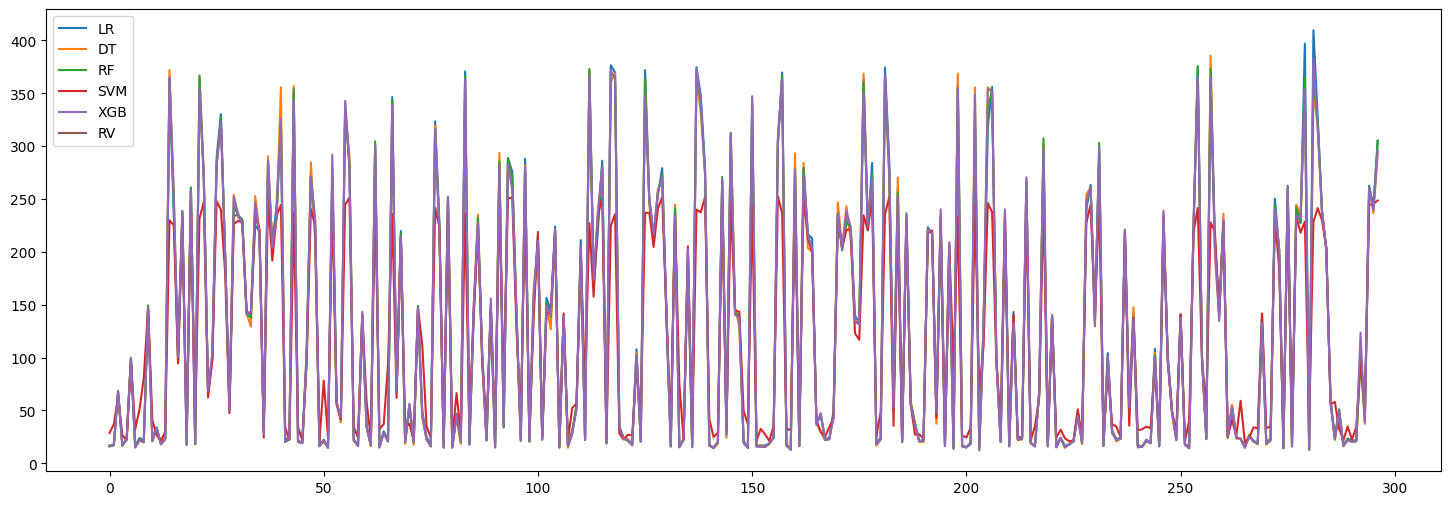

In [247]:
columns_name = ['compound' , '7_Day_MA' , '20_Day_MA']

tesla_data_market = fetch_tesla_stock_market_data(start_date = '2018-06-1' , end_date = '2022-06-2')
merged_df = merge_data(tesla_data_market, elon_tweet_df_clean , ['Close'] + columns_name)
X_train, y_train, X_test, y_test = prerprocessing_df_market(merged_df , columns_name)
result = train(X_train, y_train, X_test, y_test)
result['RV'] = y_test
result.plot(figsize=(18,6))
train_on_prophet_model(merged_df , columns_name)

5- The outcomes of Elon Musk’s tweets dataset without moving averages

LR Model:
        Mean Squared Error: 12178.836179111995
        R^2 Score: 0.14283480743673016
DT Model:
        Mean Squared Error: 7375.809590507609
        R^2 Score: 0.48087919445038063
RF Model:
        Mean Squared Error: 7346.740220051165
        R^2 Score: 0.48292514138312015
SVM Model:
        Mean Squared Error: 9964.749976297182
        R^2 Score: 0.29866559442460605


23:30:53 - cmdstanpy - INFO - Chain [1] start processing
23:30:53 - cmdstanpy - INFO - Chain [1] done processing


XGB Model:
        Mean Squared Error: 7342.05143787176
        R^2 Score: 0.48325514507317635
Prophet Model:
        Mean Squared Error: 3.308669732825914
        R^2 Score: -4.923851505948832


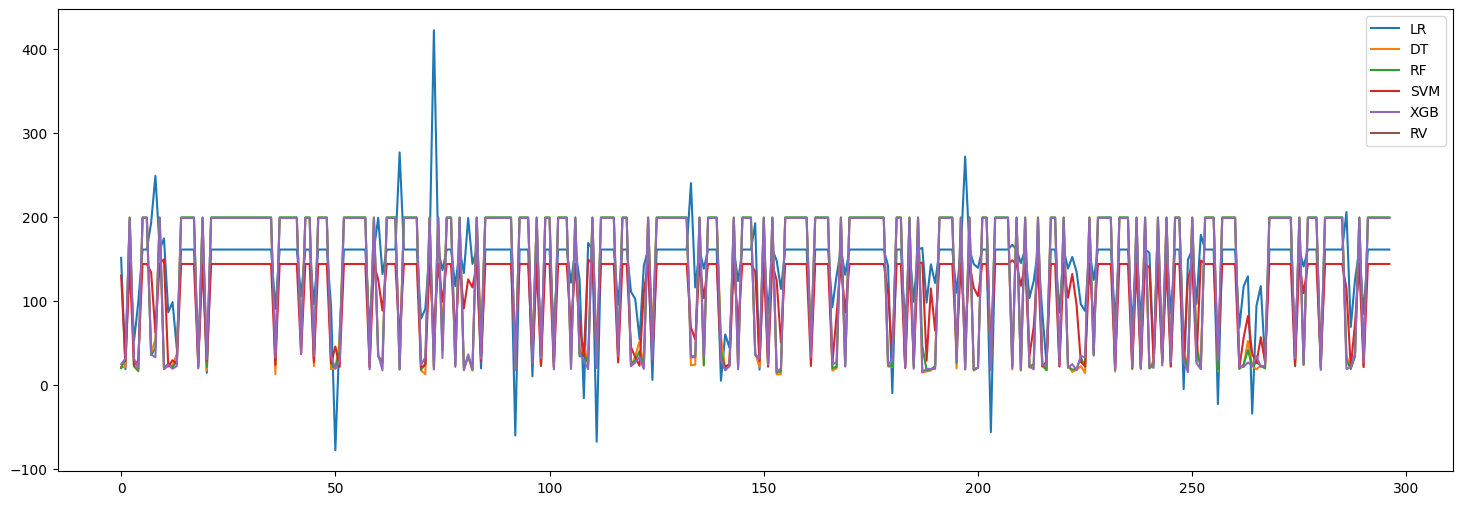

In [248]:
columns_name = ['compound']
elon_tweet_df_clean = create_clean_data_frame(elon_tweets_df)
merged_df = merge_data(tesla_data_market, elon_tweet_df_clean , ['Close'] + columns_name)
X_train, y_train, X_test, y_test = prerprocessing_df_market(merged_df , columns_name)
result = train(X_train, y_train, X_test, y_test)
result['RV'] = y_test
result.plot(figsize=(18,6))
train_on_prophet_model(merged_df , columns_name)

6- The outcomes of the tesla market without compound between '2018-06-1' - '2022-06-2'

LR Model:
        Mean Squared Error: 92.75045603608592
        R^2 Score: 0.9934720804731032
DT Model:
        Mean Squared Error: 127.52805591158817
        R^2 Score: 0.9910243795880793
RF Model:
        Mean Squared Error: 96.0214568861477
        R^2 Score: 0.9932418624102043
SVM Model:
        Mean Squared Error: 1080.0720814867361
        R^2 Score: 0.923982868305788


23:31:19 - cmdstanpy - INFO - Chain [1] start processing
23:31:19 - cmdstanpy - INFO - Chain [1] done processing


XGB Model:
        Mean Squared Error: 99.76519024192453
        R^2 Score: 0.9929783727076075
Prophet Model:
        Mean Squared Error: 0.04172926243924507
        R^2 Score: 0.9252878122919431


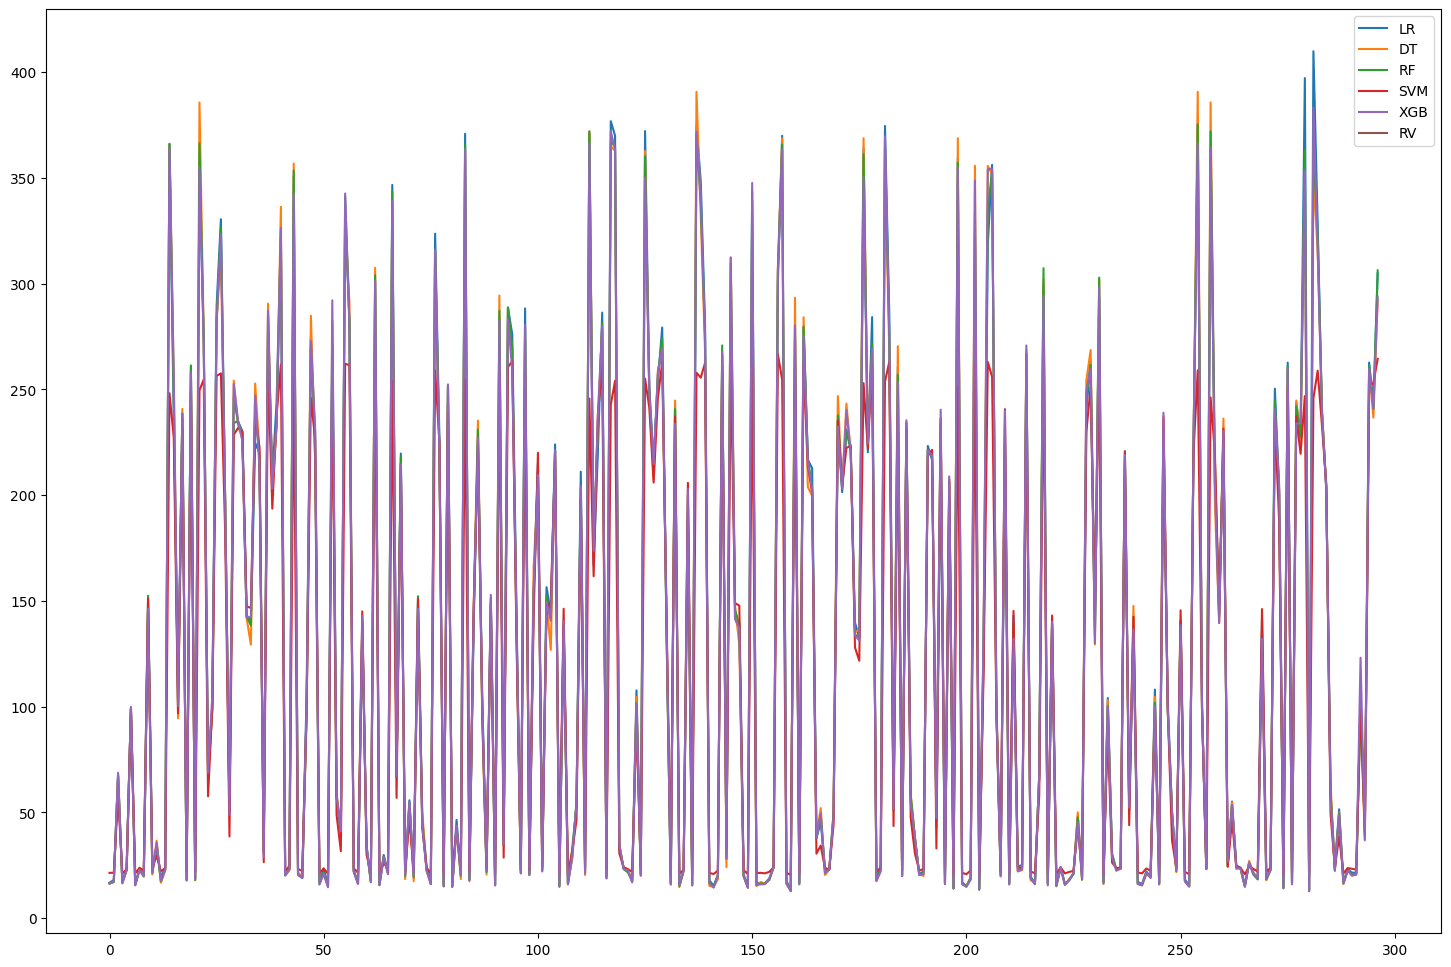

In [250]:
columns_name = ['7_Day_MA' , '20_Day_MA']
merged_df = tesla_data_market[['Close'] + columns_name]
X_train, y_train, X_test, y_test = prerprocessing_df_market(merged_df , columns_name)
result = train(X_train, y_train, X_test, y_test)
result['RV'] = y_test
result.plot(figsize=(18,12))
train_on_prophet_model(merged_df , columns_name)